# NLP on DB


- Hold a couple files out (for each score)
- also get rid of our stopwords 
- move Ed Bastian file into Good lead examples - from nyt


In [1]:
cd ..

/Users/peterwinter/Work/IDEO/highlighter


In [2]:
# Jupyter magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
# imports
import pandas as pd
from src import load_txt_files
from src import db_funcs




# import altair as alt
# import matplotlib
# import matplotlib.pyplot as plt
# import seaborn as sns

import gensim
# from gensim.corpora.textcorpus import TextCorpus
# from gensim.parsing.preprocessing import STOPWORDS


# from sklearn.metrics.pairwise import cosine_similarity

# Load DB

In [7]:
db_filename = 'docs.db'
con = db_funcs.create_connection(db_filename)
df = pd.read_sql_query("SELECT * from docs", con)
df.shape

(363, 15)

In [9]:
df.columns.tolist()

['filename',
 'group',
 'text',
 'name',
 'org',
 'headline',
 'year',
 'source',
 'url',
 'job_title',
 'publication',
 'Unnamed: 0.1',
 'date',
 'f2',
 'title']

# Load Stopwords

In [14]:
from src.nlp_preprocessing import load_stopwords #, preprocess

stopwords_path = "./1_data/stopwords/stopwords.txt"
stopwords = load_stopwords(stopwords_path)
print(f"{len(stopwords)} stopwords")

def preprocess(text, stopwords=stopwords):
    tokens = gensim.utils.simple_preprocess(text,
                                            deacc=True,
                                            min_len=3,
                                           )
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

367 stopwords


## Load IDEO docs


In [5]:
# set the path
ideo_path = '1_data/IDEO_journal'

# read all the files
ideo_titles, ideo_docs = load_txt_files.read_dir_text_files(ideo_path)

# combine into one big text block
ideo_journal_single_big_text = "\n".join(ideo_docs)

# preprocess into tokens
ideo_doc_tokens = preprocess(ideo_journal_single_big_text)


35 docs found in 1_data/IDEO_journal


## Preprocess all the documents

So far it's just get their text and tokenize it

also save the titles and directories of the docs (for later)

In [11]:
docs = df['text'].to_list()

In [17]:
tokens = [preprocess(doc) for doc in docs]
# extended_tokens = ([preprocess(doc) for doc in ideo_docs] + 
#                    [preprocess(doc) for doc in gl_docs] + 
#                    tokens)

## Make gensim dictionary

gensim object that lets us do doc2bow functions.

Keeps track of tokens + ids for each token.



In [18]:
# Could combine
full_dictionary = gensim.corpora.Dictionary(tokens)
# Right now this is just the ideo words and Good Leads words...

# add all the tokens from the documents?
# full_dictionary.add_documents(tokens)

len(full_dictionary), type(full_dictionary)

(21652, gensim.corpora.dictionary.Dictionary)

## Make Corpus object & Similarity Model

corpus is a list where each element is a BOW (list with word frequencies)

Term Frequency – Inverse Document Frequency(TF-IDF) is also a bag-of-words model but unlike the regular corpus, TFIDF down weights tokens (words) that appears frequently across documents.

In [101]:
# Create Bag of Words for IDEO + Corpus
ideo_bow = full_dictionary.doc2bow(ideo_doc_tokens)
gl_bow = full_dictionary.doc2bow(gl_tokens)
corpus = [full_dictionary.doc2bow(token) for token in tokens]

# Add IDEO to the corpus and mark it's postion
full_corpus = [ideo_bow, gl_bow] + corpus
ref_names = ['ideo', 'gl']
ref_indicies= [0, 1]


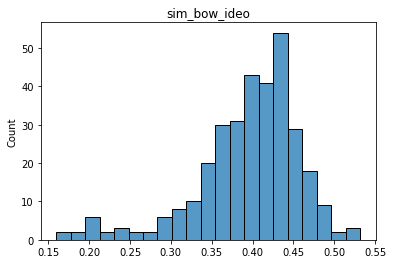

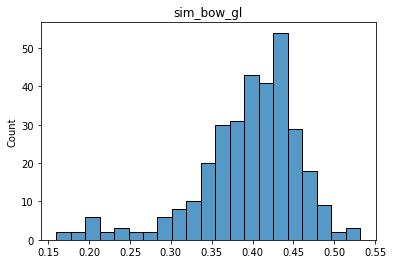

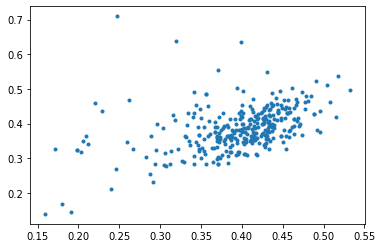

In [102]:
def similarity_to_refs(corpus, ref_indicies=[0,1]):

    sims = gensim.similarities.Similarity(output_prefix = 'workdir/',
                                          corpus=corpus,
                                          num_features=len(full_dictionary))
    
    sim_to_corpus = []
    sim_between_refs = []
    for i in ref_indicies:
        reference_array = corpus[i]
        similarity_to_refrence = sims[reference_array]
        assert similarity_to_refrence[i] > 0.99
        clean_similarity = np.delete(similarity_to_refrence, ref_indicies)
        sim_to_corpus.append(clean_similarity)
        sim_between_refs.append(similarity_to_refrence[ref_indicies]) 
        
    return sim_to_corpus, sim_between_refs
   
    
    
    
    
    
sim_name = 'bow'
new_cols = [f"sim_{sim_name}_{ref_name}" for ref_name in ref_names]
sims, ref_sims  = similarity_to_refs(corpus=full_corpus, ref_indicies=ref_indicies)
for col,sim  in zip(new_cols, sims):
    df_index[col] = sim
    
    fig, ax = plt.subplots()
    
    sns.histplot(sims[0], ax=ax)
    ax.set_title(col)
    plt.show()
    
fig, ax = plt.subplots()
ax.plot(sims[0],sims[1], '.')
plt.show()

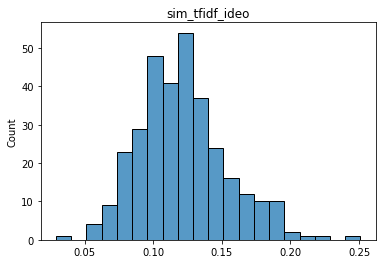

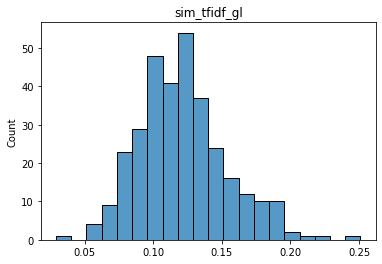

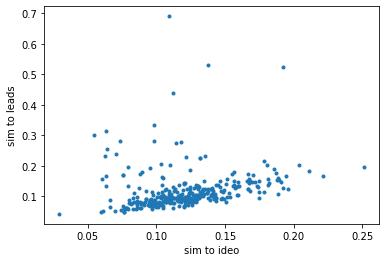

In [103]:
# 
tf_idf = gensim.models.TfidfModel(full_corpus)


sim_name = 'tfidf'
transformed_corpus = tf_idf[full_corpus]


new_cols = [f"sim_{sim_name}_{ref_name}" for ref_name in ref_names]
sims, ref_sims  = similarity_to_refs(corpus=transformed_corpus, ref_indicies=ref_indicies)
for col,sim  in zip(new_cols, sims):
    df_index[col] = sim
    
    fig, ax = plt.subplots()
    
    sns.histplot(sims[0], ax=ax)
    ax.set_title(col)
    plt.show()
    
fig, ax = plt.subplots()
ax.plot(sims[0],sims[1], '.')
ax.set_xlabel('sim to ideo')
ax.set_ylabel('sim to leads')
plt.savefig('similarity comparison.png')
plt.show()

In [108]:
def create_interactive_scatter(df, x, y, savename=None):

    color_col = 'group'

    selection = alt.selection_multi(fields=[color_col])

    color = alt.condition(selection,
                          alt.Color(f'{color_col}:N', legend=None),
                          alt.value('lightgray'))

    scatter = alt.Chart(df_index).mark_circle(size=60).encode(
        x=x,
        y=y,
        color=color,
        href='url',
        tooltip=["title", 'headline', 'group', 'url']
    ).interactive()


    legend = alt.Chart(df_index).mark_point().encode(
        y=alt.Y(f'{color_col}:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )

    if savename is not None:
        (scatter | legend).save(savename)
    
    return scatter | legend

create_interactive_scatter(df=df_index, x='sim_tfidf_ideo', y='sim_tfidf_gl', 
                           savename='tfidf.html')

alt.HConcatChart(...)

In [109]:
df_index.columns

Index(['group', 'name', 'org', 'headline', 'year', 'source', 'url',
       'job_title', 'publication', 'title', 'sim_bow_ideo', 'sim_bow_gl',
       'sim_tfidf_ideo', 'sim_tfidf_gl'],
      dtype='object')

## Actually pretty bad correlation between similarity scores

In [110]:
# fig, ax = plt.subplots()
# ax.plot(df_index['similarity_bow'], df_index['similarity_tfidf'], '.')
# # ax.set_xlim(0, 1)
# # ax.set_ylim(0,1)
# ax.set_ylabel('tf idf')
# ax.set_xlabel('bow word counts')
# ax.set_title('correlation between similarities')
# plt.show()

# Mess with Doc2Vec

In [111]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.spatial.distance import cosine

In [119]:
tagged_data = [TaggedDocument(words=t, tags=[str(i)]) for i, t in enumerate(tokens)]
len(tagged_data)

323

In [123]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =0)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v_dm0_short.model")
print("Model Saved")

/Users/peterwinter/Work/IDEO/highlighter/.venv/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/peterwinter/Work/IDEO/highlighter/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [131]:
def similarity(doc_vectors, ref_vector):
    return [1 - cosine(ref_vector, doc_vectors[i]) for i in range(len(tokens))]



# model_file = "d2v_short.model"
# model_file = "d2v_long.model"
model_file = "d2v_dm0_short.model"
# model_file = "d2v_dm0_long.model"

sname = model_file.split(".")[0]

model= Doc2Vec.load(model_file)


ideo_vector = model.infer_vector(ideo_doc_tokens)
gl_vector = model.infer_vector(gl_tokens)

y_name = 'sim_doc2vec_ideo'
x_name = 'sim_doc2vec_gl'

df_index[x_name] = similarity(doc_vectors=model.docvecs, ref_vector=ideo_vector)
df_index[y_name] = similarity(doc_vectors=model.docvecs, ref_vector=gl_vector)


create_interactive_scatter(df=df_index, x=x_name, y=y_name, 
                           savename=f'{sname}.html')

alt.HConcatChart(...)

In [128]:
len(docs[0]), len(tokens[0])

(22429, 1552)

In [133]:
x_name = 'sim_doc2vec_ideo'
y_name = 'sim_tfidf_ideo'

sname = 'ideo_similarity_diff'

create_interactive_scatter(df=df_index, x=x_name, y=y_name, 
                           savename=f'{sname}.html')

alt.HConcatChart(...)

In [134]:
x_name = 'sim_doc2vec_gl'
y_name = 'sim_tfidf_gl'

sname = 'gl_similarity_diff'

create_interactive_scatter(df=df_index, x=x_name, y=y_name, 
                           savename=f'{sname}.html')

alt.HConcatChart(...)

In [136]:
# df_index
char_counts = []
token_counts = []
unique_tokens = []

for i, (doc, tok) in enumerate(zip(docs, tokens)):
    char_counts.append(len(doc))
    token_counts.append(len(tok))
    unique_tokens.append(len(set(tok)))

df_index['char_count'] = char_counts
df_index['token_counts'] = token_counts
df_index['unique_token'] = unique_tokens


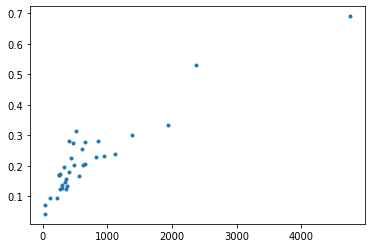

In [142]:
# sub_df = df_index[df_index['group'] == 'good_lead_articles']
# fig, ax = plt.subplots()
# ax.plot(sub_df['char_count'], sub_df['sim_tfidf_gl'], '.')
# plt.show()

fig, ax = plt.subplots()
ax.plot(sub_df['token_counts'], sub_df['sim_tfidf_gl'], '.')
plt.show()

# fig, ax = plt.subplots()
# ax.plot(sub_df['token_counts'], sub_df['char_count'], '.')
# plt.show()

# Viz Customization Code
## TODO: add to python scripts

In [ ]:
# from https://github.com/altair-viz/altair/issues/1422

import altair as alt
import pandas as pd

two_charts_template = """
<!DOCTYPE html>
<html>
<head>
  <script src="https://cdn.jsdelivr.net/npm/vega@{vega_version}"></script>
  <script src="https://cdn.jsdelivr.net/npm/vega-lite@{vegalite_version}"></script>
  <script src="https://cdn.jsdelivr.net/npm/vega-embed@{vegaembed_version}"></script>
</head>
<body>

<div id="vis1"></div>
<div id="vis2"></div>

<script type="text/javascript">
  vegaEmbed('#vis1', {spec1}).catch(console.error);
  vegaEmbed('#vis2', {spec2}).catch(console.error);
</script>
</body>
</html>
"""


df = pd.DataFrame({'x': range(5), 'y': range(5)})

chart1 = alt.Chart(df).mark_point().encode(x='x', y='y')
chart2 = alt.Chart(df).mark_line().encode(x='x', y='y')

with open('charts.html', 'w') as f:
    f.write(two_charts_template.format(
        vega_version=alt.VEGA_VERSION,
        vegalite_version=alt.VEGALITE_VERSION,
        vegaembed_version=alt.VEGAEMBED_VERSION,
        spec1=chart1.to_json(indent=None),
        spec2=chart2.to_json(indent=None),
    ))